In [1]:
import os
import csv
import warnings
import numpy as np
import torch
import oem
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path

warnings.filterwarnings("ignore")

In [2]:
OEMDIR = "/home/bruno/riken_openearthmap/LULC-RIKEN/integrated"
TRAIN_LIST = "data/train.txt"
VAL_LIST = "data/val.txt"
IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

R = 0.2

In [3]:
img_paths = [f for f in Path(OEMDIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt("data/test.txt", dtype=str)]

print("Total samples      :", len(img_paths), len(img_paths) * R)
print("Training samples   :", len(train_fns), len(train_fns) * R)
print("Validation samples :", len(val_fns), len(val_fns) * R)
print("Testing samples    :", len(test_fns), len(test_fns) * R)

Total samples      : 5000 1000.0
Training samples   : 3000 600.0
Validation samples : 500 100.0
Testing samples    : 1500 300.0


In [4]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
        ],
        )

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
        ],
        )        

In [16]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

train_data_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        num_workers=10,
        shuffle=True,
        drop_last=True,
    )
val_data_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=BATCH_SIZE // 2,
        num_workers=10,
        shuffle=False,
    )

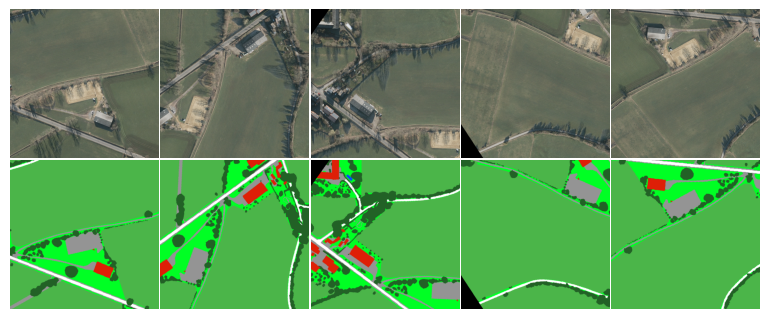

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

for i in range(5):
    img, msk, fn = train_data[41]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.tools.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [7]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()

In [17]:
max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )    


Epoch: 1


Train:   4%|▍         | 32/750 [00:24<09:03,  1.32it/s, Loss=7.21, Score=0.0531]


ValueError: Caught ValueError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/bruno/apps/miniconda3/envs/pcc/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/bruno/apps/miniconda3/envs/pcc/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/bruno/apps/miniconda3/envs/pcc/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/media/gdrive8tb/riken_openearthmap/open_earth_map/oem/dataset.py", line 44, in __getitem__
    data = self.augm({"image": img, "mask": msk})
  File "/home/bruno/apps/miniconda3/envs/pcc/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 94, in __call__
    img = t(img)
  File "/media/gdrive8tb/riken_openearthmap/open_earth_map/oem/transforms.py", line 44, in __call__
    i = random.randrange(0, h - self.size[0])
  File "/home/bruno/apps/miniconda3/envs/pcc/lib/python3.9/random.py", line 316, in randrange
    raise ValueError("empty range for randrange() (%d, %d, %d)" % (istart, istop, width))
ValueError: empty range for randrange() (0, -74, -74)
